# Aircontrol Camera API

## Camera Placement
AirControl Airplane has two cameras. One is in the Cockpit and another is a follow camera. 
Both the camera can be used for capturing screenshots while in flight.

## Python API
Python API has a `set_camera` function to set the camera properties. 
`set_camera` function takes the following arguments:
- InputControlType (str, optional): It can be either `Code` or `Other`. This is to control the internal mechanism and prevent repeated calling in already set variables. 
- If `InputControlType` is set to 'Code', the camera cannot be controlled from Keyboard or Joystick. If `InputControlType` is set to 'Other', the camera can be only controlled from Keyboard or Joystick.  Defaults to "Code". 
- ActiveCamera (int, optional): Aircontrol Airplane has two cameras inside the Cockpit and outside the Airplane. The Camera inside the Cockpit is indexed as 0. The outside of the Airplane is indexed as 1. `ActiveCamera` can be used to select the scene camera. Defaults to 1.
- IsCapture (bool, optional): `Iscapture` if true the screenshot will be captured. Defaults to False.
- CaptureCamera (int, optional): `CaptureCamera` defines which camera should be used for capturing the scene. Defaults to 1.
- CaptureType (int, optional): Choose between different capture types. Defaults to 1.
- CaptureWidth (int, optional): Width of the captured image. Defaults to 256.
- CaptureHeight (int, optional): Height of the captured image. Defaults to 256.
- IsOutput (bool, optional): By default `set_camera` function only sets the internal state. `set_camera` only provides log output and not the actual captured image. `set_control` when called it returns the actual output. IF you want to force `set_camera` to return the image, set `IsOutput` to True. Defaults to False.


**Capture Types**

One of the main challenges in Machine Learning is the task of getting large amounts of training data in the right format. Deep learning, and machine learning more generally, needs huge training sets to work properly. Virtual worlds can provide a wealth of training data. However, it must consist of more than just the final image: object categorization, optical flow, etc

`Capture Types` can be set to the following:

| Capture Type | Type                  | Details                                                                                                                       |
|--------------|-----------------------|-------------------------------------------------------------------------------------------------------------------------------|
| 0            | Scene Capture         |       Capture from scene Camera                                 |
| 1            | Instance Segmentation | Each object in the scene gets unique color                                                                                    |
| 2            | Semantic segmentation | Objects are assigned color based on their category                                                                            |
| 3            | Depth                 | Pixels are colored according to their motion in the relation to the camera     
| 4            | Normals               | Surfaces are colored according to their orientation in relation to the camera                                                        |
| 5            | Optical Flow          | Pixels are colored according to their distance from the camera (Only visible when Airplane or Object in reference are moving) |

##  Implementation details

First of all `AC_Airplane_CameraController.OnSceneChange()` calls ColorEncoding class to encode unique object idenitifier and layer as RGB color. These colors are stored in MaterialPropertyBlock for each object and are automatically passed into the shaders when rendering.

Upon start `AC_Airplane_CameraController` component creates hidden camera for every single pass of output data (image segmentation, optical flow, depth, etc). These cameras allow to override usual rendering of the scene and instead use custom shaders to generate the output. These cameras are attached to different scene camera using `Camera.targetDisplay property` - handy for preview in the Editor.

For Image segmentation and Object categorization pass special replacement shader is set with `Camera.SetReplacementShader(). It overrides shaders that would be otherwise used for rendering and instead outputs encoded object id or layer.

Optical flow and Depth pass cameras request additional data to be rendered with `DepthTextureMode.Depth` and `DepthTextureMode.MotionVectors` flags. Rendering of these cameras is followed by drawing full screen quad `CommandBuffer.Blit()` with custom shaders that convert 24/16bit-per-channel data into the 8-bit RGB encoding.


## Importing Requirements

In [1]:
import sys
from pprint import pprint
import PIL.Image as Image
import base64
import numpy as np
from io import BytesIO
from matplotlib.pyplot import  imshow
import matplotlib.pyplot as plt

In [2]:
from airctrl import environment 
from airctrl import sample_generator
from airctrl.utils import unity
A =  environment.Trigger()
L = unity.Launch()
port = 5000
process = L.launch_executable("/home/supatel/Games/AirControl_2021/Build/1.3.0/Linux/v1.3.0-AirControl.x86_64", server_port=port)

Now call method `.get_connected(port=<Default 8053>)` to get connected

Loading environment from /home/supatel/Games/AirControl_2021/Build/1.3.0/Linux/v1.3.0-AirControl.x86_64 at port 5000 client ip 127.0.1.1 client port 5000

Sleeping for 5 seconds to allow environment load

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"

In [3]:
# get connected to server
A.get_connected(port=port)

Connecting with port 5000



## Examples (Cockpit Camera)

**Scene Capture**

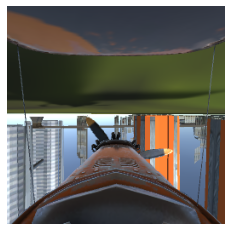

In [51]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=1,CaptureType=0,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Instance Segmentation**

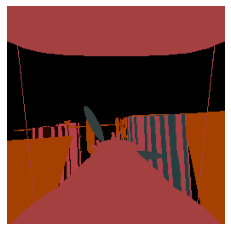

In [49]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=1,CaptureType=1,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Semantic segmentation**

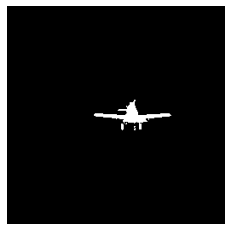

In [47]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=0,CaptureType=2,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Depth**

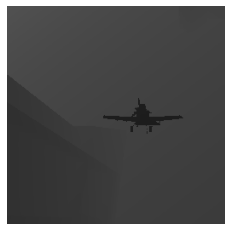

In [45]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=0,CaptureType=3,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Normals**

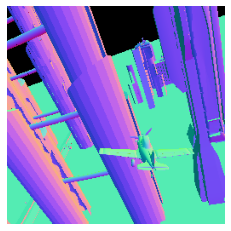

In [40]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=0,CaptureType=4,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Optical Flow**

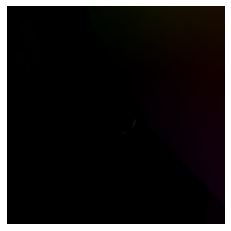

In [43]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=0,CaptureType=5,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

## Example (External Camera)

**Scene Capture**

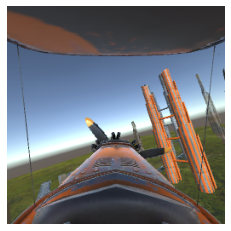

In [35]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=1,CaptureType=0,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Instance Segmentation**

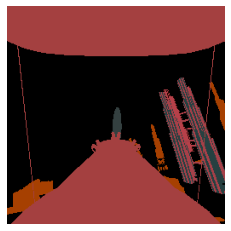

In [33]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=1,CaptureType=1,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Semantic segmentation**

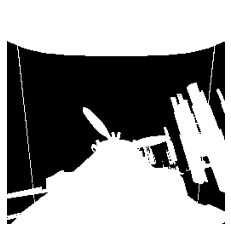

In [31]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=1,CaptureType=2,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Depth**

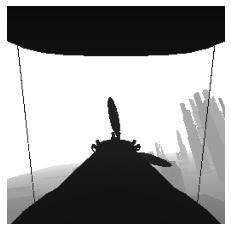

In [28]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=1,CaptureType=3,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Normals**

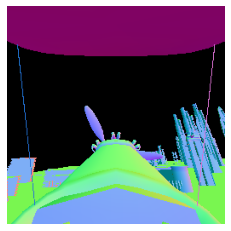

In [24]:
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=1,CaptureType=4,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

**Optical Flow**

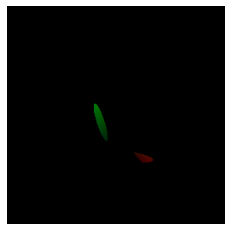

In [26]:
## no movement no optcal flow
output = A.set_camera(ActiveCamera=1, IsCapture=True,CaptureCamera=1,CaptureType=5,CaptureHeight=256,CaptureWidth=256,IsOutput=True)
image = output['ScreenCapture']
if image != "":
    im = Image.open(BytesIO(base64.b64decode(image)))
    imshow(np.asarray(im))
    plt.axis('off')

# Reference
1. [Replacement Shaders](https://docs.unity3d.com/Manual/SL-ShaderReplacement.html)
2. [Command Buffers](https://docs.unity3d.com/Manual/GraphicsCommandBuffers.html)
3. [Depth and Motion Vectors](https://docs.unity3d.com/Manual/SL-CameraDepthTexture.html)
4. [MaterialPropertyBlock](https://docs.unity3d.com/ScriptReference/MaterialPropertyBlock.html)